<a href="https://colab.research.google.com/github/EastbayML/VariationalInference/blob/main/BayesianNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%matplotlib inline
import numpy as np
import torch
from torch import nn
from sklearn import datasets
from torch import dist
import matplotlib.pyplot as plt
#from IPython.display import clear_output
import copy

In [2]:
def plotdist(m,X,Y):# draw samples from Q(theta)
    plt.figure(figsize=(16, 6))
    plt.scatter(X, Y)
    if m:
        with torch.no_grad():
          y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)
        
        # Get some quantiles
        q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)


        plt.plot(X, mu)
        plt.fill_between(X.flatten(), q1, q2, alpha=0.2)

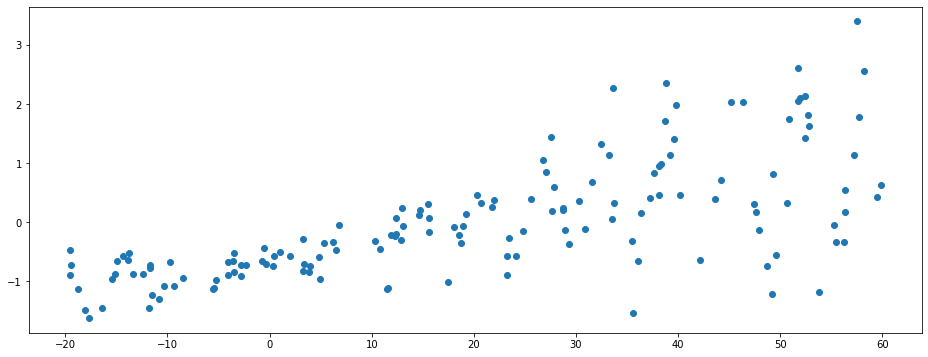

In [3]:
import numpy as np
import torch
from torch import nn
from sklearn import datasets
import matplotlib.pyplot as plt

w0 = 0.125
b0 = 5.
x_range = [-20, 60]

np.random.seed(43)

def load_dataset(n=150, n_tst=150):
    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    y = (y - y.mean()) / y.std()
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    return y[:, None], x[:, None]

y, x = load_dataset()
plotdist(None,x,y)

In [4]:
def det_loss(y, y_pred, mu, log_var):    
    reconstruction_error = (0.5 * (y - y_pred)**2).sum()
    kl_divergence = (-0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp()))

    return (reconstruction_error + kl_divergence).sum()

In [5]:
def ll_gaussian(y, mu, log_var):
    sigma = torch.exp(0.5 * log_var)
    return -0.5 * torch.log(2 * np.pi * sigma**2) - (1 / (2 * sigma**2))* (y-mu)**2

In [6]:
class LinearVariational(nn.Module):
    """
    Mean field approximation of nn.Linear
    """
    def __init__(self, in_features, out_features, parent, n_batches, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.include_bias = bias        
        self.parent = parent
        self.n_batches = n_batches
        
        if getattr(parent, 'accumulated_kl_div', None) is None:
            parent.accumulated_kl_div = 0
            
        # Initialize the variational parameters.
        # 𝑄(𝑤)=N(𝜇_𝜃,𝜎2_𝜃)
        # Do some random initialization with 𝜎=0.001
        self.w_mu = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=0, std=0.001)
        )
        # proxy for variance
        # log(1 + exp(ρ))◦ eps
        self.w_p = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=-2.5, std=0.001)
        )
        if self.include_bias:
            self.b_mu = nn.Parameter(
                torch.zeros(out_features)
            )
            # proxy for variance
            self.b_p = nn.Parameter(
                torch.zeros(out_features)
            )
        
    def reparameterize(self, mu, p):
        sigma = torch.log(1 + torch.exp(p)) 
        eps = torch.randn_like(sigma)
        return mu + (eps * sigma)
    
    def kl_divergence(self, z, mu_theta, p_theta, prior_sd=1):
        #log_prior = dist.Normal(0, prior_sd).log_prob(z) 
        #log_p_q = dist.Normal(mu_theta, torch.log(1 + torch.exp(p_theta))).log_prob(z) 
        log_prior = ll_gaussian(z,torch.zeros(1),torch.log(1 + torch.exp( torch.ones(1)) ))
        log_p_q = ll_gaussian(z,mu_theta, torch.log(1 + torch.exp(p_theta)))
        return (log_p_q - log_prior).sum() / self.n_batches

    def forward(self, x):
        w = self.reparameterize(self.w_mu, self.w_p)
        
        if self.include_bias:
            b = self.reparameterize(self.b_mu, self.b_p)
        else:
            b = 0
            
        z = x @ w + b
        
        self.parent.accumulated_kl_div += self.kl_divergence(w, 
                                                             self.w_mu,
                                                             self.w_p, 
                                                             )
        if self.include_bias:
            self.parent.accumulated_kl_div += self.kl_divergence(b, 
                                                                 self.b_mu, 
                                                                 self.b_p,
                                                                 )
        return z

In [7]:
#@dataclass
class KL:
    accumulated_kl_div = 0

class Model(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, n_batches):
        super().__init__()
        self.kl_loss = KL
        
        self.layers = nn.Sequential(
            LinearVariational(in_size, hidden_size, self.kl_loss, n_batches),
            nn.ReLU(),
            LinearVariational(hidden_size, hidden_size, self.kl_loss, n_batches),
            nn.ReLU(),
            LinearVariational(hidden_size, out_size, self.kl_loss, n_batches)
        )
    
    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div
    
    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0
            
    def forward(self, x):
        return self.layers(x)

In [11]:
epochs = 2000

def det_loss(y, y_pred, model):
    batch_size = y.shape[0]
    reconstruction_error = -ll_gaussian(y,y_pred, torch.ones(1)).sum()
    #reconstruction_error = -dist.Normal(y_pred, .1).log_prob(y).sum()
    kl = model.accumulated_kl_div
    model.reset_kl_div()
    return reconstruction_error + kl

m = Model(1, 20, 1, n_batches=1)
optim = torch.optim.Adam(m.parameters(), lr=0.01)

X = torch.tensor(x, dtype=torch.float)
Y = torch.tensor(y, dtype=torch.float)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = m(X)
    loss = det_loss(y_pred, Y, m)
    loss.backward()
    optim.step()

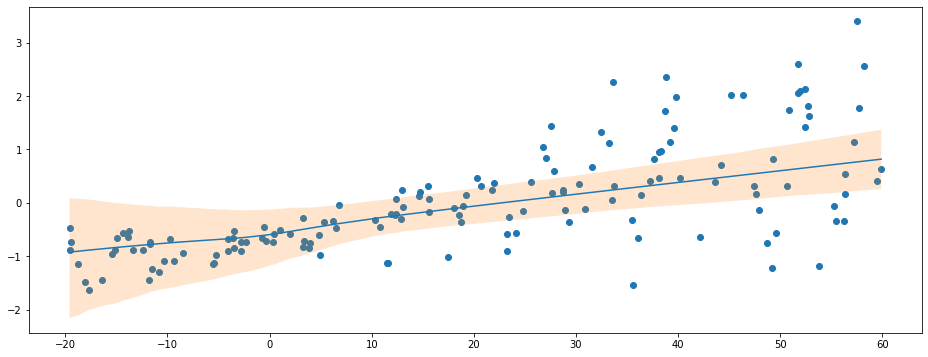

In [12]:
with torch.no_grad():
    trace = np.array([m(X).flatten().numpy() for _ in range(1000)]).T
q_25, q_95 = np.quantile(trace, [0.05, 0.95], axis=1)
plt.figure(figsize=(16, 6))
plt.plot(X, trace.mean(1))
plt.scatter(X, Y)
plt.fill_between(X.flatten(), q_25, q_95, alpha=0.2)